In [1]:
# ===================== IMPORTS/LIBRARIES =====================
from luxpy import (cat, colortf, _CIEOBS, _CIE_ILLUMINANTS, _CRI_RFL, _CIE_D65,_CIE_E,
                   spd_to_xyz, plot_color_data, math, cie_interp, getwlr, xyz_to_srgb)
from luxpy.utils import np, plt, sp, _PKG_PATH, _SEP, _EPS 
import warnings
from imageio import imsave

import tensorflow as tf
from mtcnn import MTCNN
from pathlib import Path
import pandas as pd
import glob
import cv2
import csv
import os
import ast
import pydot
import pydotplus
import graphviz
from datetime import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from keras.utils.vis_utils import plot_model

In [2]:
# ===================== CSV HISTORY FUNCTIONS =====================

def historyToCsv(history):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    current_datetime = datetime.now()

    # Convert the datetime object to a string
    filename_friendly_datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    
    # save to csv: 
    hist_csv_file = 'history' + filename_friendly_datetime_string + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def csvToHistory(csv_filename):
    # Read the CSV file into a pandas DataFrame
    hist_df = pd.read_csv(csv_filename, index_col=0)

    # Convert the DataFrame to a dictionary
    history_dict = hist_df.to_dict(orient='list')

    return history_dict

In [3]:
# # add to imports
# from tensorflow.keras.optimizers import Adam

# # ===================== MULTITASK MODEL SETUP =====================
# base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3)
# )

# # NOTE: MULTITASK BASE (NO CHANGES) // Anica
# # - learning rate no change 0.0001
# # - no dropouts(0.2 / 0.5)
# # - no batch normalization

# flattened_features = tf.keras.layers.Flatten(name='flattened_features')(base_model.output)

# embedding_layer = tf.keras.layers.Dense(512, activation='linear', name='embedding')(flattened_features)

# additional_dense_layer1 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense1')(embedding_layer)
# # additional_Dropout_layer1 = tf.keras.layers.Dropout(0.2)(additional_dense_layer1)
# additional_dense_layer2 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense2')(additional_dense_layer1)
# # additional_Norm_layer1 = tf.keras.layers.BatchNormalization()(additional_dense_layer2)
# # additional_dense_layer11 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer11')(additional_dense_layer2)
# # additional_dense_layer12 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer12')(additional_dense_layer11)
# # additional_dense_layer13 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer13')(additional_dense_layer12)
# # additional_dense_layer14 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer14')(additional_dense_layer13)

# additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(embedding_layer)
# # additional_Dropout_layer2 = tf.keras.layers.Dropout(0.2)(additional_dense_layer3)
# additional_dense_layer4 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense4')(additional_dense_layer3)

# # landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer14)
# landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer2)
# illum = tf.keras.layers.Dense(1, activation='linear', name='previous_illuminance_output')(additional_dense_layer4)

# # Reshape layer to the desired shape
# reshaped_features = tf.keras.layers.Reshape((8, 8, 8))(embedding_layer)

# # Conv2DTranspose layers instead of UpSampling2D
# conv_transpose1 = tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', padding='same', strides=(7, 7))(reshaped_features)
# conv_transpose2 = tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose1)
# conv_transpose3 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose2)

# retIllum = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', name='image_retinex_output')(conv_transpose3 )

# task_outputs = None

# task_outputs = [landmarks, illum, retIllum]

# multi_task_model = tf.keras.Model(inputs=base_model.input, outputs=task_outputs)

# # Compile the model with specific loss functions and metrics for each task
# multi_task_model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss={
#         'landmark_output': 'mean_squared_error',
#         'previous_illuminance_output': 'mean_squared_error',
#         'image_retinex_output': 'mean_squared_error'
#     },
#     metrics={
#         'landmark_output': ['mse', "mae"],
#         'previous_illuminance_output': ['mse', "mae"],
#         'image_retinex_output': ['mse', "mae"]
#     }
# )

# multi_task_model.summary()

In [4]:
# # add to imports
# from tensorflow.keras.optimizers import Adam

# # ===================== MULTITASK MODEL SETUP =====================
# base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3)
# )

# # NOTE: MULTITASK W/ Dropouts (0.5) //Ace
# # - edited retinex
# # - added dropouts with every dense(0.5)

# flattened_features = tf.keras.layers.Flatten(name='flattened_features')(base_model.output)
# embedding_layer = tf.keras.layers.Dense(512, activation='linear', name='embedding')(flattened_features)

# # FOR LANDMARKS
# additional_Dropout_layer1 = tf.keras.layers.Dropout(0.5)(embedding_layer)

# additional_dense_layer1 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense1')(additional_Dropout_layer1)
# additional_Dropout_layer2 = tf.keras.layers.Dropout(0.5)(additional_dense_layer1)

# additional_dense_layer2 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense2')(additional_Dropout_layer2)
# additional_Dropout_layer3 = tf.keras.layers.Dropout(0.5)(additional_dense_layer2)

# # BATCH NORMALIZATION
# # additional_Norm_layer1 = tf.keras.layers.BatchNormalization()(additional_dense_layer2)

# # ADDITIONAL DENSE LAYERS
# # additional_dense_layer11 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer11')(additional_dense_layer2)
# # additional_dense_layer12 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer12')(additional_dense_layer11)
# # additional_dense_layer13 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer13')(additional_dense_layer12)
# # additional_dense_layer14 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense_layer14')(additional_dense_layer13)

# # FOR ILLUMINANCE
# additional_Dropout_layer4 = tf.keras.layers.Dropout(0.5)(embedding_layer)

# additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(additional_Dropout_layer4)
# additional_Dropout_layer5 = tf.keras.layers.Dropout(0.5)(additional_dense_layer3)

# additional_dense_layer4 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense4')(additional_Dropout_layer5)
# additional_Dropout_layer6 = tf.keras.layers.Dropout(0.5)(additional_dense_layer4)

# # landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer14)

# # LANDMARK AND ILLUM OUTPUT
# landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_Dropout_layer3)
# illum = tf.keras.layers.Dense(1, activation='linear', name='previous_illuminance_output')(additional_Dropout_layer6)

# # FOR RETINEX
# # Reshape layer to the desired shape
# reshaped_features = tf.keras.layers.Reshape((8, 8, 8))(embedding_layer)

# # Conv2DTranspose layers instead of UpSampling2D
# conv_transpose1 = tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', padding='same', strides=(1, 1))(reshaped_features)
# conv_transpose2 = tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose1)
# conv_transpose3 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))(conv_transpose2)
# conv_transpose4 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(7, 7))(conv_transpose3)

# # RETINEX OUTPUT
# retIllum = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', name='image_retinex_output')(conv_transpose4)

# task_outputs = None

# task_outputs = [landmarks, illum, retIllum]

# multi_task_model = tf.keras.Model(inputs=base_model.input, outputs=task_outputs)

# # Compile the model with specific loss functions and metrics for each task
# multi_task_model.compile(
#     optimizer=Adam(learning_rate=1e-6),
#     loss={
#         'landmark_output': 'mean_squared_error',
#         'previous_illuminance_output': 'mean_squared_error',
#         'image_retinex_output': 'mean_squared_error'
#     },
#     metrics={
#         'landmark_output': ['mse', "mae"],
#         'previous_illuminance_output': ['mse', "mae"],
#         'image_retinex_output': ['mse', "mae"]
#     }
# )

# multi_task_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

 spose)                         )                                                                 
                                                                                                  
 landmark_output (Dense)        (None, 10)           650         ['dropout_2[0][0]']              
                                                                                                  
 previous_illuminance_output (D  (None, 1)           65          ['dropout_5[0][0]']              
 ense)                                                                                            
                                                                                                  
 image_retinex_output (Conv2D)  (None, 224, 224, 3)  867         ['conv2d_transpose_3[0][0]']     
                                                                                                  
Total params: 27,651,462
Trainable params: 27,651,462
Non-trainable params: 0
_______________________________

In [16]:
# ===================== MULTITASK MODEL SETUP =====================

input_layer = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv1')(input_layer)
maxpool1 = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool1')(conv1)
dropout1 = tf.keras.layers.Dropout(0.2, name='dropout1')(maxpool1)

# Second Convolutional Block
conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv2')(dropout1)
maxpool2 = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool2')(conv2)
dropout2 = tf.keras.layers.Dropout(0.2, name='dropout2')(maxpool2)

# Third Convolutional Block
conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', name='conv3')(dropout2)
maxpool3 = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool3')(conv3)
dropout3 = tf.keras.layers.Dropout(0.2, name='dropout3')(maxpool3)

# Flatten Layer
flatten = tf.keras.layers.Flatten(name='flatten')(dropout3)

# Embedding Layer
embedding = tf.keras.layers.Dense(256, activation='relu', name='embedding')(flatten)
dropout4 = tf.keras.layers.Dropout(0.2, name='dropout4')(embedding)

# Landmarks Layers
landmarksDense_1 = tf.keras.layers.Dense(64, activation='relu', name='landmarksDense_1')(dropout4)
landmarksDropout1 = tf.keras.layers.Dropout(0.2, name='landmarksDropout1')(landmarksDense_1)
landmarksDense_2 = tf.keras.layers.Dense(64, activation='relu', name='landmarksDense_2')(landmarksDropout1)
landmarksDropout2 = tf.keras.layers.Dropout(0.2, name='landmarksDropout2')(landmarksDense_2)
landmarks = tf.keras.layers.Dense(10, activation='relu', name='landmark_output')(landmarksDropout2)

# Illuminance Layers
illuminanceDense_1 = tf.keras.layers.Dense(64, activation='relu', name='illuminanceDense_1')(dropout4)
illuminanceDropout1 = tf.keras.layers.Dropout(0.2, name='illuminanceDropout1')(illuminanceDense_1)
illuminanceDense_2 = tf.keras.layers.Dense(64, activation='relu', name='illuminanceDense_2')(illuminanceDropout1)
illuminanceDropout2 = tf.keras.layers.Dropout(0.2, name='illuminanceDropout2')(illuminanceDense_2)
illum = tf.keras.layers.Dense(1, activation='relu', name='previous_illuminance_output')(illuminanceDropout2)

# Retinex Layers

# Reshape
reshape = tf.keras.layers.Reshape((4, 4, 16), name='reshape')(dropout4)

# Deconvolution Block 1
deconv1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), activation='relu', name='deconv1')(reshape)
dropout1 = tf.keras.layers.Dropout(0.2, name='retinexDropout1')(deconv1)
upsample1 = tf.keras.layers.UpSampling2D((2, 2), name='upsample1')(dropout1)  # Adjust size

# Deconvolution Block 2
deconv2 = tf.keras.layers.Conv2DTranspose(64, (4, 4), activation='relu', name='deconv2')(upsample1)
dropout2 = tf.keras.layers.Dropout(0.2, name='retinexDropout2')(deconv2)
upsample2 = tf.keras.layers.UpSampling2D((2, 2), name='upsample2')(dropout2)  # Adjust size

# Deconvolution Block 3
deconv3 = tf.keras.layers.Conv2DTranspose(32, (7, 7), activation='relu', name='deconv3')(upsample2)
dropout3 = tf.keras.layers.Dropout(0.2, name='retinexDropout3')(deconv3)
upsample3 = tf.keras.layers.UpSampling2D((7, 7), name='upsample3')(dropout3)  # Adjust size

# Conv2D layer for final output
retIllum = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', name='image_retinex_output')(upsample3)

task_outputs = [landmarks, illum, retIllum]

multi_task_model = tf.keras.Model(inputs=input_layer, outputs=task_outputs)

# Compile the model with specific loss functions and metrics for each task
multi_task_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'landmark_output': 'mean_squared_error',
        'previous_illuminance_output': 'mean_squared_error',
        'image_retinex_output': 'mean_squared_error'
    },
    metrics={
        'landmark_output': ['mse', "mae"],
        'previous_illuminance_output': ['mse', "mae"],
        'image_retinex_output': ['mse', "mae"]
    }
)

# Summary of the multi-task model
multi_task_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 222, 222, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 111, 111, 64  0           ['conv1[0][0]']                  
                                )                                                           

In [5]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


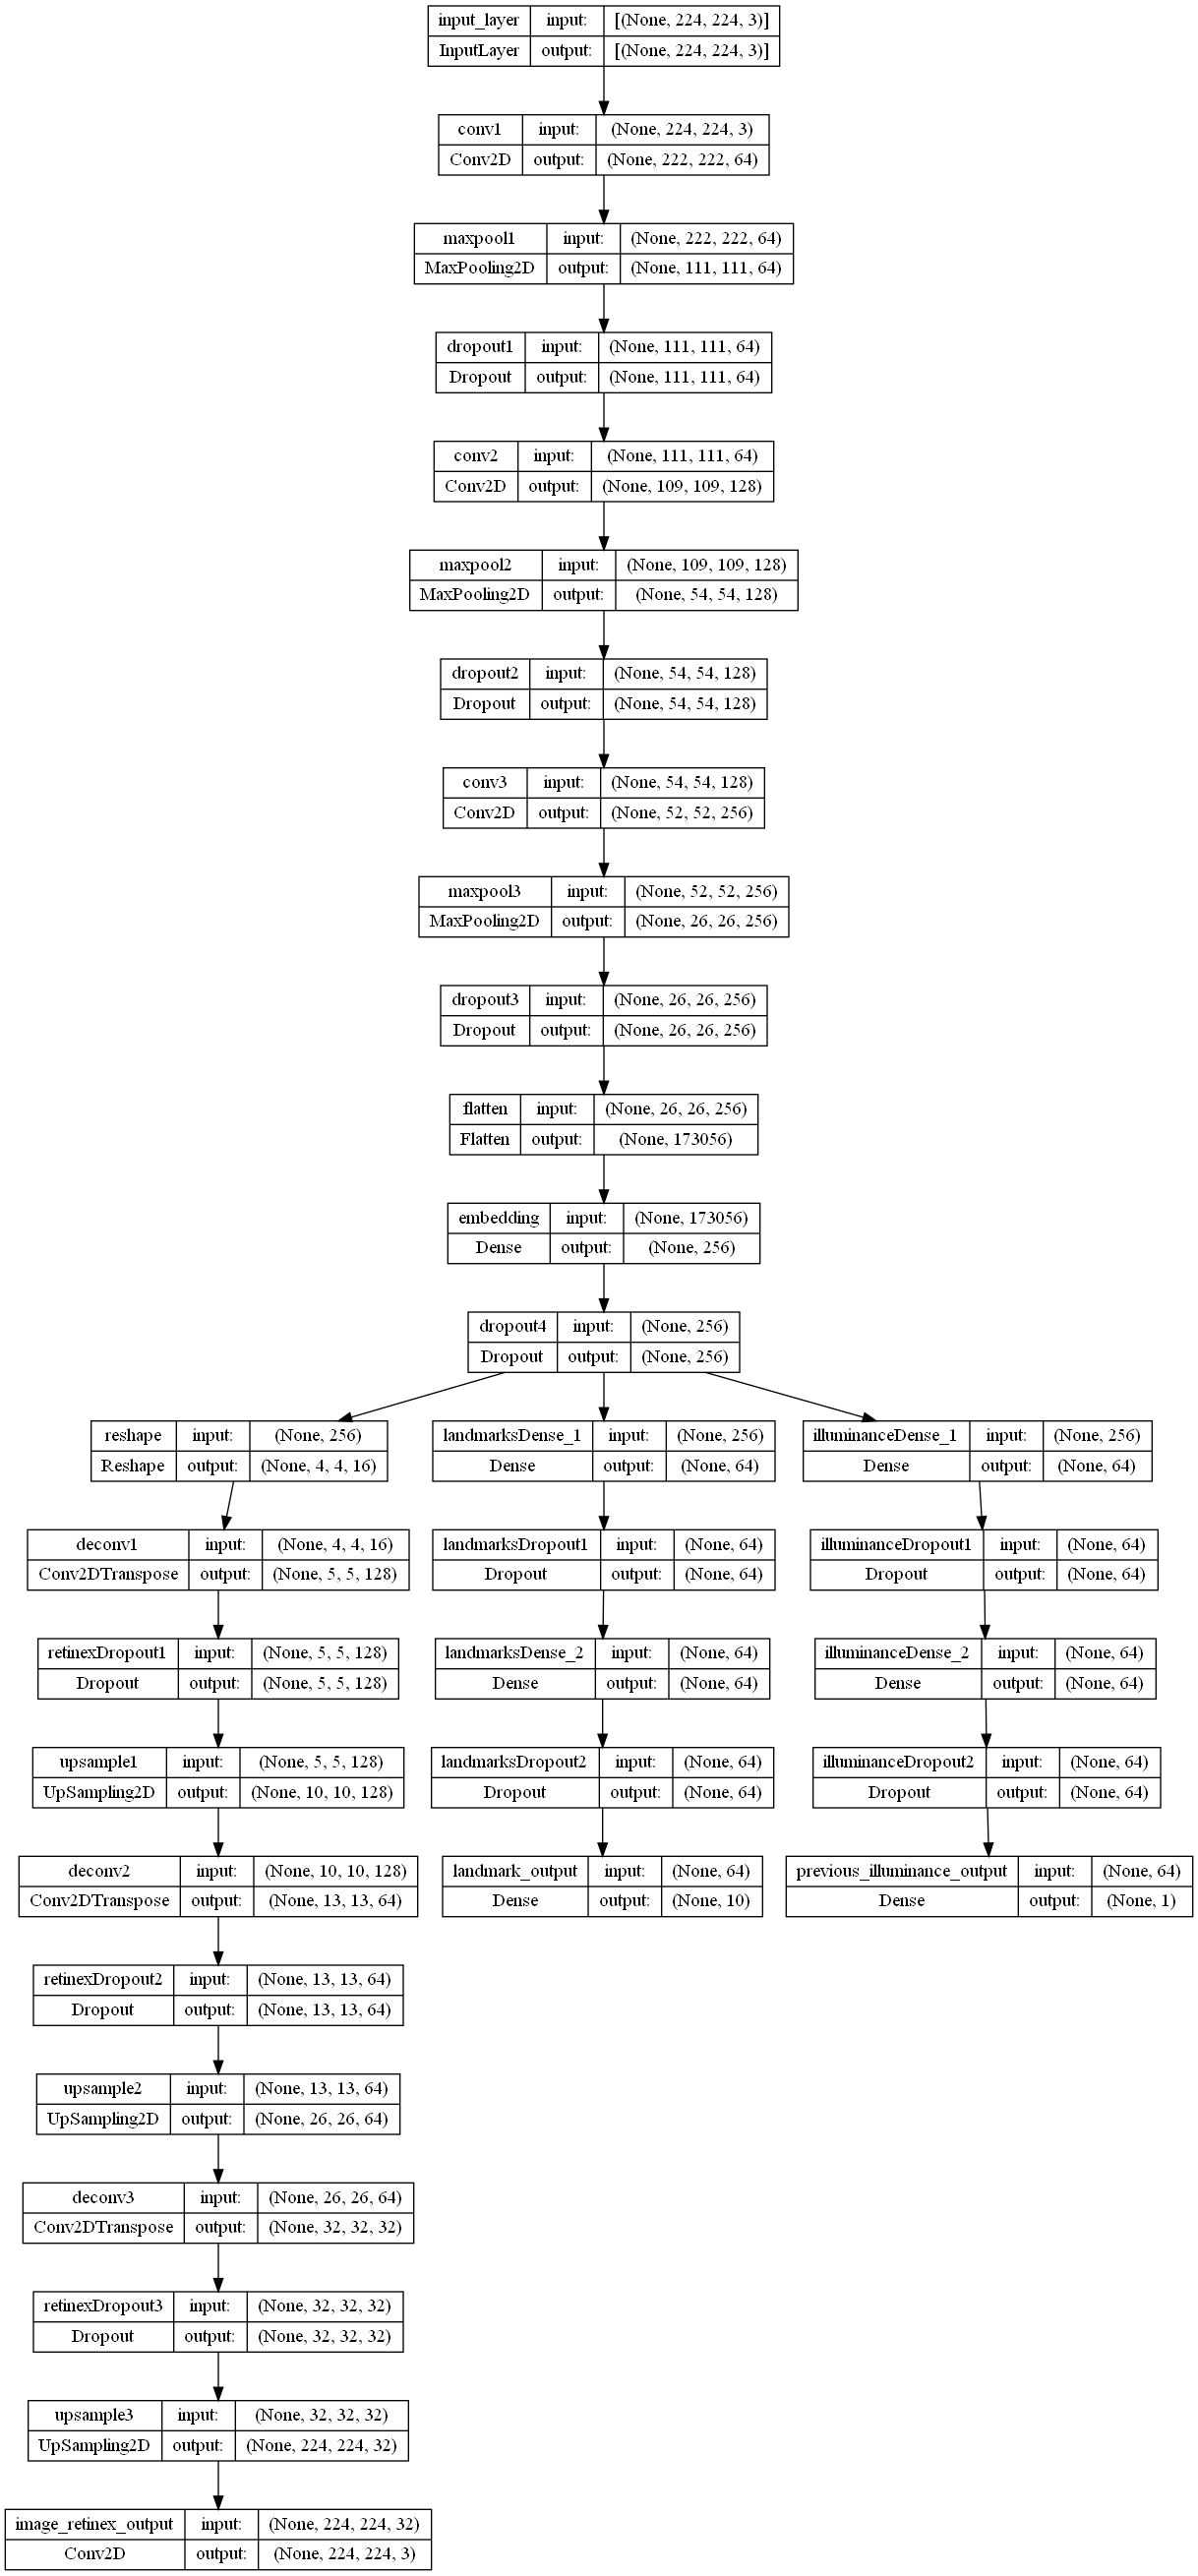

In [17]:
import pydot
import graphviz
import matplotlib.pyplot as plt
tf.keras.utils.plot_model(multi_task_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# # ===================== MULTI-TASK DATA GEN =====================

# class CustomDataGen(tf.keras.utils.Sequence):
    
#     def __init__(self, df, X_col, y_col,
#                  batch_size,
#                  input_size=(224, 224, 3),
#                  shuffle=True,
#                  random_seed=None):  # Add a new parameter for random seed
        
#         self.df = df.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.input_size = input_size
#         self.shuffle = shuffle
#         self.random_seed = random_seed  # Store the random seed
        
#         self.n = len(self.df)
#         self.n_coords = 2  # Assuming landmark coordinates are 2-dimensional
#         self.n_illuminance = 1  # Assuming a single illuminance value
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)  # Use the random seed
    
#     def __get_input(self, path, target_size):
    
#         image = tf.keras.preprocessing.image.load_img(path)
#         image_arr = tf.keras.preprocessing.image.img_to_array(image)

#         image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()

#         return image_arr / 255.
    
#     def __get_output(self, label, output_type):
#         # Assuming output_type is 'coordinates', 'illuminance', or 'adjusted_image_path'
#         if output_type == 'coordinates':
#             # Assuming label is a string containing a dictionary-like structure
#             # Safely evaluate the string as a literal dictionary using ast.literal_eval
#             coordinates_dict = ast.literal_eval(label)
            
#             # Extract x and y coordinates for each landmark
#             landmarks = ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']
#             coordinates_list = [coordinates_dict[landmark] for landmark in landmarks]
            
#             # Flatten the list and convert to numpy array
#             coordinates_array = np.array([coord for landmark_coords in coordinates_list for coord in landmark_coords])
#             print(f'original coords: {coordinates_array}')
            
# #             print("Shape of landmarks_array:", coordinates_array.shape)
            
#             # If there are exactly 10 values, return the array, otherwise raise an error
#             if len(coordinates_array) == 10:
#                 return coordinates_array
#             else:
#                 raise ValueError("Expected 10 coordinates, but found {}".format(len(coordinates_array)))
#         elif output_type == 'illuminance':
#             # Convert the illuminance value to a float
#             return float(label)
#         elif output_type == 'adjusted_image_path':
#             # Assuming label is the path to the adjusted image
#             return self.__get_input(label, self.input_size)
    
#     def __get_data(self, batches):
#         # Generates data containing batch_size samples

#         path_batch = batches[self.X_col['path']]
        
#         coords_batch = batches[self.y_col['coordinates']]
#         illuminance_batch = batches[self.y_col['illuminance']]
#         adjusted_image_path_batch = batches[self.y_col['adjusted_image_path']]

#         X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

#         y0_batch = np.asarray([self.__get_output(y, 'coordinates') for y in coords_batch])
#         y1_batch = np.asarray([self.__get_output(y, 'illuminance') for y in illuminance_batch])
#         y2_batch = np.asarray([self.__get_output(y, 'adjusted_image_path') for y in adjusted_image_path_batch])
        
#         return X_batch, [y0_batch, y1_batch, y2_batch]
    
#     def __getitem__(self, index):
#         batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
#         X, y = self.__get_data(batches)
        
#         return X, y
    
#     def __len__(self):
#         return self.n // self.batch_size

In [8]:
# ===================== MULTI-TASK DATA GEN =====================

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True,
                 random_seed=None):  # Add a new parameter for random seed
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.random_seed = random_seed  # Store the random seed
        
        self.n = len(self.df)
        self.n_coords = 2  # Assuming landmark coordinates are 2-dimensional
        self.n_illuminance = 1  # Assuming a single illuminance value
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)  # Use the random seed
    
    def __get_input(self, path, target_size):
    
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()

        return image_arr / 255.
    
    def __get_output(self, label, output_type):
        # Assuming output_type is 'coordinates', 'illuminance', or 'adjusted_image_path'
        if output_type == 'coordinates':
            # Assuming label is a string containing a dictionary-like structure
            # Safely evaluate the string as a literal dictionary using ast.literal_eval
            coordinates_dict = ast.literal_eval(label)
            
            # Extract x and y coordinates for each landmark
            landmarks = ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']
            coordinates_list = [coordinates_dict[landmark] for landmark in landmarks]
            
            # Flatten the list and convert to numpy array
            coordinates_array = np.array([coord for landmark_coords in coordinates_list for coord in landmark_coords])
            
            coordinates_array = normalize_coordinates(coordinates_array, 640, 480)

#             print("Shape of landmarks_array:", coordinates_array.shape)
            
            # If there are exactly 10 values, return the array, otherwise raise an error
            if len(coordinates_array) == 10:
                return coordinates_array
            else:
                raise ValueError("Expected 10 coordinates, but found {}".format(len(coordinates_array)))
        elif output_type == 'illuminance':
            # Convert the illuminance value to a float
            return float(label)
        elif output_type == 'adjusted_image_path':
            # Assuming label is the path to the adjusted image
            return self.__get_input(label, self.input_size)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
        
        coords_batch = batches[self.y_col['coordinates']]
        illuminance_batch = batches[self.y_col['illuminance']]
        adjusted_image_path_batch = batches[self.y_col['adjusted_image_path']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

        y0_batch = np.asarray([self.__get_output(y, 'coordinates') for y in coords_batch])
        y1_batch = np.asarray([self.__get_output(y, 'illuminance') for y in illuminance_batch])
        y2_batch = np.asarray([self.__get_output(y, 'adjusted_image_path') for y in adjusted_image_path_batch])

        return X_batch, [y0_batch, y1_batch, y2_batch]
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

def normalize_coordinates(coordinates, original_width, original_height):
    normalized_coordinates = np.zeros_like(coordinates, dtype=np.float32)
    
    for i in range(0, len(coordinates), 2):
        x = coordinates[i]
        y = coordinates[i + 1]
        
        normalized_x = (x / original_width)
        normalized_y = (y / original_height)
        
        normalized_coordinates[i] = normalized_x
        normalized_coordinates[i + 1] = normalized_y
    
    return normalized_coordinates

In [9]:
# ===================== DATA GEN SETUP =====================

train_df = pd.read_csv(r".\training.csv") # path to train_data csv
train_df["Filename"] = "./data/Training/" + train_df["Filename"]
train_df["Retinex"] = "./retinex_results_train/" + train_df["Retinex"]

# Define column indices or names for X and y
X_col = {'path': 'Filename'}
y_col = {'illuminance': 'Illuminance', 'coordinates': 'Landmarks', 'adjusted_image_path': 'Retinex'}

# Create an instance of CustomDataGen
train_gen = CustomDataGen(train_df, X_col, y_col, batch_size=32, input_size=(224, 224, 3), random_seed=438)

eval_df = pd.read_csv(r".\evaluation.csv") # path to eval_data csv
eval_df["Filename"] = "./data/Evaluation/" + eval_df["Filename"]
eval_df["Retinex"] = "./retinex_results_eval/" + eval_df["Retinex"]

# Define column indices or names for X and y
eval_X_col = {'path': 'Filename'}
eval_y_col = {'illuminance': 'Illuminance', 'coordinates': 'Landmarks', 'adjusted_image_path': 'Retinex'}

val_gen = CustomDataGen(eval_df, eval_X_col, eval_y_col, batch_size=32, input_size=(224, 224, 3), random_seed=438)
# print(eval_df)
# print(train_df)

In [10]:
class DynamicLearningRateScheduler(Callback):
    def __init__(self, monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6):
        super(DynamicLearningRateScheduler, self).__init__()
        self.monitor_metric = monitor_metric
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.wait = 0
        self.best_metric = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.monitor_metric)

        if current_metric is None:
            raise ValueError(f"Metric {self.monitor_metric} not found in training logs.")

        if current_metric < self.best_metric:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.model.optimizer.lr * self.factor, self.min_lr)
                self.model.optimizer.lr = new_lr
                print(f"\nLearning rate reduced to {new_lr}.")
                self.wait = 0

dynamicLearningCallback = DynamicLearningRateScheduler(monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# class SaveModelEveryNEpochs(Callback):
#     def __init__(self, save_path, save_freq=5):
#         super(SaveModelEveryNEpochs, self).__init__()
#         self.save_path = save_path
#         self.save_freq = save_freq

#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch + 1) % self.save_freq == 0:
#             model_filename = f"{self.save_path}_epoch_{epoch + 1}.keras"
#             self.model.save(model_filename)
#             print(f"\nModel saved to {model_filename}.")

# callback_save_path = "./Callback_Models"  # Change this to your desired save path
# saveModelCallback = SaveModelEveryNEpochs(callback_save_path, save_freq=5)

In [11]:
history = multi_task_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[dynamicLearningCallback])

Epoch 1/20
940/940 [==============================] - 2152s 2s/step - loss: 1.8996 - landmark_output_loss: 0.8187 - previous_illuminance_output_loss: 0.6311 - image_retinex_output_loss: 0.4499 - landmark_output_mse: 0.8187 - landmark_output_mae: 0.6744 - previous_illuminance_output_mse: 0.6311 - previous_illuminance_output_mae: 0.5357 - image_retinex_output_mse: 0.4499 - image_retinex_output_mae: 0.6282 - val_loss: 0.6960 - val_landmark_output_loss: 0.2147 - val_previous_illuminance_output_loss: 0.0514 - val_image_retinex_output_loss: 0.4299 - val_landmark_output_mse: 0.2147 - val_landmark_output_mae: 0.4453 - val_previous_illuminance_output_mse: 0.0514 - val_previous_illuminance_output_mae: 0.2075 - val_image_retinex_output_mse: 0.4299 - val_image_retinex_output_mae: 0.6065
Epoch 2/20
940/940 [==============================] - 1975s 2s/step - loss: 0.7734 - landmark_output_loss: 0.2551 - previous_illuminance_output_loss: 0.0715 - image_retinex_output_loss: 0.4468 - landmark_output_mse

940/940 [==============================] - 1842s 2s/step - loss: 0.5517 - landmark_output_loss: 0.1394 - previous_illuminance_output_loss: 0.0159 - image_retinex_output_loss: 0.3964 - landmark_output_mse: 0.1394 - landmark_output_mae: 0.3151 - previous_illuminance_output_mse: 0.0159 - previous_illuminance_output_mae: 0.0991 - image_retinex_output_mse: 0.3964 - image_retinex_output_mae: 0.5867 - val_loss: 0.4666 - val_landmark_output_loss: 0.0829 - val_previous_illuminance_output_loss: 0.0079 - val_image_retinex_output_loss: 0.3757 - val_landmark_output_mse: 0.0829 - val_landmark_output_mae: 0.2753 - val_previous_illuminance_output_mse: 0.0079 - val_previous_illuminance_output_mae: 0.0829 - val_image_retinex_output_mse: 0.3757 - val_image_retinex_output_mae: 0.5623
Epoch 12/20
940/940 [==============================] - 1771s 2s/step - loss: 0.5380 - landmark_output_loss: 0.1345 - previous_illuminance_output_loss: 0.0152 - image_retinex_output_loss: 0.3883 - landmark_output_mse: 0.1345 -

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/image_retinex_output/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\CG\miniconda3\envs\torch\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\CG\miniconda3\envs\torch\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\CG\miniconda3\envs\torch\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\CG\miniconda3\envs\torch\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\CG\miniconda3\envs\torch\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\CG\AppData\Local\Temp\ipykernel_32316\3385505024.py", line 1, in <module>
      history = multi_task_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[dynamicLearningCallback])
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\CG\miniconda3\envs\torch\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/image_retinex_output/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[32,224,224,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/image_retinex_output/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4285]

In [ ]:
# ===================== SAVE MODEL WEIGHTS =====================

multi_task_model.save('MultiTaskModelWithDropout50.keras')
history.history

In [ ]:
# ===================== PLOT MULTI TASK MODEL =====================
# MODEL LOSS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# LANDMARK LOSS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_loss'])
plt.plot(history.history['val_landmark_output_loss'])
plt.title('Landmarks Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# LANDMARK MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_mse'])
plt.plot(history.history['val_landmark_output_mse'])
plt.title('Landmarks Task MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# LANDMARK MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_mae'])
plt.plot(history.history['val_landmark_output_mae'])
plt.title('Landmarks Task MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# ILLUMS LOSS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_loss'])
plt.plot(history.history['val_previous_illuminance_output_loss'])
plt.title('Illuminance Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# ILLUMS MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_mse'])
plt.plot(history.history['val_previous_illuminance_output_mse'])
plt.title('Illuminance Task MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# ILLUMS MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_mae'])
plt.plot(history.history['val_previous_illuminance_output_mae'])
plt.title('Illuminance Task MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# RETINEX LOSS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_loss'])
plt.plot(history.history['val_image_retinex_output_loss'])
plt.title('Retinex Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# RETINEX MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_mse'])
plt.plot(history.history['val_image_retinex_output_mse'])
plt.title('Landmarks Task MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# RETINEX MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_mae'])
plt.plot(history.history['val_image_retinex_output_mae'])
plt.title('Landmarks Task MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_loss'])
plt.plot(history.history['val_landmark_output_loss'])
plt.title('Landmarks Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_mse'])
plt.plot(history.history['val_landmark_output_mse'])
plt.title('Landmarks Task MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['landmark_output_mae'])
plt.plot(history.history['val_landmark_output_mae'])
plt.title('Landmarks Task MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_loss'])
plt.plot(history.history['val_previous_illuminance_output_loss'])
plt.title('Illuminance Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_mse'])
plt.plot(history.history['val_previous_illuminance_output_mse'])
plt.title('Illuminance Task MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['previous_illuminance_output_mae'])
plt.plot(history.history['val_previous_illuminance_output_mae'])
plt.title('Illuminance Task MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_loss'])
plt.plot(history.history['val_image_retinex_output_loss'])
plt.title('Retinex Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_mse'])
plt.plot(history.history['val_image_retinex_output_mse'])
plt.title('Retinex Task MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_mae'])
plt.plot(history.history['val_image_retinex_output_mae'])
plt.title('Retinex Task MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()